## This script is used to present the whole pipeline which includes the following 5 parts:
- Bubble Detector
- OCR
- Translation
- Text Removal
- Placement

## Text Detector

In [5]:
import skimage.transform as trans
from data import *
import skimage.io as io
import skimage.transform as trans
import numpy as np
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from models.unet import *

import cv2
import numpy as np
import matplotlib.pyplot as plt
import PIL
import html
from PIL import Image
import xml.etree.ElementTree as ET
import textwrap
from PIL import Image, ImageFont, ImageDraw
from keras.preprocessing import image
from imageio import imread

from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TerminateOnNaN, CSVLogger
from keras import backend as K
# from keras.models import load_model
from math import ceil
import numpy as np
import pytesseract
import re
from matplotlib import pyplot as plt

from models.keras_ssd300 import ssd_300
from keras_loss_function.keras_ssd_loss import SSDLoss
from keras_layers.keras_layer_AnchorBoxes import AnchorBoxes
from keras_layers.keras_layer_DecodeDetections import DecodeDetections
from keras_layers.keras_layer_DecodeDetectionsFast import DecodeDetectionsFast
from keras_layers.keras_layer_L2Normalization import L2Normalization

from ssd_encoder_decoder.ssd_input_encoder import SSDInputEncoder
from ssd_encoder_decoder.ssd_output_decoder import decode_detections, decode_detections_fast

from data_generator.object_detection_2d_geometric_ops import Resize
from data_generator.object_detection_2d_photometric_ops import ConvertTo3Channels
from data_generator.data_augmentation_chain_original_ssd import SSDDataAugmentation
from data_generator.object_detection_2d_misc_utils import apply_inverse_transforms

%matplotlib inline

## 1. Setup
### 1.1 parpameters

In [6]:
img_height = 300 # Height of the model input images
img_width = 300 # Width of the model input images
img_channels = 3 # Number of color channels of the model input images
mean_color = [123, 117, 104] # The per-channel mean of the images in the dataset. Do not change this value if you're using any of the pre-trained weights.
swap_channels = [2, 1, 0] # The color channel order in the original SSD is BGR, so we'll have the model reverse the color channel order of the input images.
n_classes = 1 # Number of positive classes, e.g. 20 for Pascal VOC, 80 for MS COCO
scales_pascal = [0.1, 0.2, 0.37, 0.54, 0.71, 0.88, 1.05] # The anchor box scaling factors used in the original SSD300 for the Pascal VOC datasets
scales = scales_pascal
aspect_ratios = [[1.0, 2.0, 0.5],
                 [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                 [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                 [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                 [1.0, 2.0, 0.5],
                 [1.0, 2.0, 0.5]] # The anchor box aspect ratios used in the original SSD300; the order matters
two_boxes_for_ar1 = True
steps = [8, 16, 32, 32, 64, 100] # The space between two adjacent anchor box center points for each predictor layer.
offsets = [0.5, 0.5, 0.5, 0.5, 0.5, 0.5] # The offsets of the first anchor box center points from the top and left borders of the image as a fraction of the step size for each predictor layer.
clip_boxes = False # Whether or not to clip the anchor boxes to lie entirely within the image boundaries
variances = [0.1, 0.1, 0.2, 0.2] # The variances by which the encoded target coordinates are divided as in the original implementation
normalize_coords = True

### 1.2 Load a previously created model

In [8]:
%%time
# TODO: Set the path to the `.h5` file of the model to be loaded.
model_path = 'checkpoint/ssd300_all.h5'

# We need to create an SSDLoss object in order to pass that to the model loader.
ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=0.8)

K.clear_session() # Clear previous models from memory.

model = load_model(model_path, custom_objects={'AnchorBoxes': AnchorBoxes,
                                               'L2Normalization': L2Normalization,
                                               'compute_loss': ssd_loss.compute_loss})

model2 = unet()
model2.load_weights("checkpoint/unet_8.hdf5")

/Users/panziqi/Desktop/Mlator/to_wtq/models/unet.py:55: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`
  model = Model(input = inputs, output = conv10)


CPU times: user 4.09 s, sys: 458 ms, total: 4.55 s
Wall time: 2.86 s


## 2. Make predictions

You can set the `shuffle` option to `False` if you would like to check the model's progress on the same image(s) over the course of the training.

In [9]:
orig_images = [] # Store the images here.
input_images = [] # Store resized versions of the images here.
# We'll only load one image in this example.
img_path = 'examples/1.jpg'
# img_load = imread(img_path)
img_load = Image.open(img_path).convert("RGB")
    
orig_images.append(np.array(img_load))
img = image.load_img(img_path, target_size=(img_height, img_width))
img = image.img_to_array(img) 
input_images.append(img)
input_images = np.array(input_images)

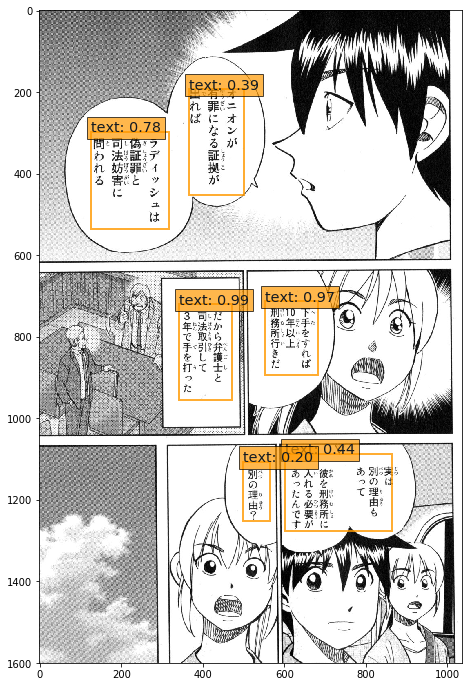

In [10]:
# 1: Set the generator for the predictions.
batch_original_images = orig_images
batch_images = input_images
# i = 0 # Which batch item to look at

# 2: Make predictions.
y_pred = model.predict(input_images)

# 3: Decode the raw predictions in `y_pred`.

y_pred_decoded = decode_detections(y_pred,
                                   confidence_thresh=0.194,
                                   iou_threshold=0.01,
                                   top_k=200,
                                   normalize_coords=normalize_coords,
                                   img_height=img_height,
                                   img_width=img_width)

# 4: Convert the predictions for the original image + manual offset.
# decode
y_pred_decoded_inv = y_pred_decoded.copy()
y_pred_decoded_inv[0][:,2] = y_pred_decoded[0][:,2]* orig_images[0].shape[1] / img_width-3
y_pred_decoded_inv[0][:,3] = y_pred_decoded[0][:,3]* orig_images[0].shape[0] / img_height-3
y_pred_decoded_inv[0][:,4] = y_pred_decoded[0][:,4]* orig_images[0].shape[1] / img_width+23
y_pred_decoded_inv[0][:,5] = y_pred_decoded[0][:,5]* orig_images[0].shape[0] / img_height+23


np.set_printoptions(precision=2, suppress=True, linewidth=90)
i = 0
# 5: Draw the predicted boxes onto the image
# Set the colors for the bounding boxes
colors = plt.cm.hsv(np.linspace(0, 1, n_classes+1)).tolist()
classes = ['background','text']

plt.figure(figsize=(20,12))
plt.imshow(orig_images[i])

current_axis = plt.gca()

for box in y_pred_decoded_inv[0]:
    # Transform the predicted bounding boxes for the 300x300 image to the original image dimensions.
    xmin = box[2]
    ymin = box[3]
    xmax = box[4]
    ymax = box[5]
    
    color = colors[int(box[0])]
    label = '{}: {:.2f}'.format(classes[int(box[0])], box[1])
    current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color="#FF9900", fill=False, linewidth=2,alpha=0.8))  
    current_axis.text(xmin, ymin, label, size='x-large', color='#131A22', bbox={'facecolor':"#FF9900", 'alpha':0.7})    
    
# output text_box in this script
text_box = []
for y_pred_decode in y_pred_decoded_inv:
    text_box.append(y_pred_decode[:,2:].astype(np.int32))

## OCR+Translate

In [11]:
# Imports the Google Cloud client library
from google.cloud import translate
import six
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="nmt-API-07b7802bb743.json"
# /Users/panziqi/Desktop/Mlator/ssd_keras/nmt-API-07b7802bb743.json
translate_client = translate.Client()
target = 'en'

In [12]:
class TransGT(object):
    def __init__(self, text, source_language ='ja'):
        self.text = text
        self.source_language = source_language
    def translator(self):
        translated = translate_client.translate(
            self.text,
            source_language = self.source_language,
            model=translate.NMT
            )
        return translated['translatedText']

In [13]:
def crop_words(img, boxes):
    """
    make sure that the vertices of all boxes are inside the image
    """
    words = []
    for j in range(len(boxes)):
        h, w = img.shape[:2]
        if boxes.shape[1] == 4:
            # box case
            box = boxes[j]
            xmin, ymin, xmax, ymax = box
            if xmin==xmax:
                xmax+=5
            if ymin==ymax:
                ymax+=5
            
            word_w, word_h = xmax - xmin, ymax - ymin
            word_ar = word_w / word_h
            word = img[ymin:ymax,xmin:xmax,:]
        words.append(word)
    return words

In [14]:
%%time
text_ocr = []
crop_page = []
ocr_page = []
ocr_page_tran = []
text_ocr_tran = []
text_box_clean = []

r = re.compile(r'[-A-Za-z0-9(){}\[\]\【/|~《》』]+')
r2 = re.compile(r'[二リp:"=]+')

for i,bm in enumerate(batch_original_images):
    cropped = crop_words(bm,text_box[i])
    
    cropped_filter = []
    mask = []
    for j in range(len(cropped)):
        h,w,_ = cropped[j].shape
        if h<w/1.5:
            continue
        cropped_filter.append(cropped[j])
        mask.append(j)
        
    text_box_clean.append(text_box[i][mask])
        
    for cp in cropped_filter:
        ret,img2 = cv2.threshold(cp,110,250,cv2.THRESH_BINARY)
#         t = pytesseract.image_to_string(img2, lang='jpn_vert1+chi_tra_vert',config="--psm 5 --oem 3")
        t = pytesseract.image_to_string(img2, lang='jpn_vert1+chi_tra_vert',config="--psm 12 --oem 3")
        t = r.sub(' ',t).split()
        t = "".join(t)
        t = r2.sub('!!',t)
        eng= TransGT(t)
        eng = html.unescape(eng.translator())
        eng = eng.replace('sum','?')
        text_ocr.append(t)
        text_ocr_tran.append(eng)
        
        
    crop_page.append(cropped_filter)
    ocr_page.append(np.array(text_ocr))
    ocr_page_tran.append(np.array(text_ocr_tran))
    
    

CPU times: user 84.9 ms, sys: 63.3 ms, total: 148 ms
Wall time: 5.35 s


In [15]:
text_ocr

['了チ護士と引して年で手を打っ上',
 '下手をすれば年以上務所月行きだ',
 'ラディッシュは偽証因と司法妨害に問われる',
 '人另@理あって彼を刑務入れる必要があったんです',
 'オニオンが有罪になる証拠が!!れば',
 '讓']

In [16]:
ocr_page_tran

[array(['Take a hand with Yori Chi',
        'It is going to the office monthly for more than a year if I do poor',
        'Radish is questioned for perpetrators and jud',
        'It was necessary to put him in prison for humanity @ reason',
        'If the evidence that Onion is guilty !!', 'Moth'], dtype='<U67')]

## Create Mask

In [17]:
%%time
img_L = img_load.convert("L")
img_array = np.array(img_L)
sh = img_array.shape
print(sh)
img_rz = trans.resize(img_array,(256,256,1))
img_rz = np.expand_dims(img_rz,axis=0)
pred = model2.predict(img_rz)>0.2
mask = trans.resize(pred[0][:,:,0],sh)

(1600, 1036)


/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


CPU times: user 5.44 s, sys: 2.14 s, total: 7.59 s
Wall time: 1.15 s


## Insert Font

In [18]:
# Word Level fill in 
def text_fill(image, axis, text, mask):
    
    # Turn the image into array
    im_array = np.array(image)
    im_array[mask==1]=255
    masked_im = Image.fromarray(im_array)
    
    # Set default font_size to 12
    font_size = 12
    font = ImageFont.truetype("mangat.ttf", font_size)
    space = 5
#     return im_array
    for coord, t in zip(axis[0],text):

        # Set default text color to white
        text_color = 0
        # Set default background to white
        bg = 255
        # Calculate the width and height of text bubbles
        width = coord[2]-coord[0]
        height = coord[3]-coord[1]

        if im_array[coord[1]:coord[3],coord[0]:coord[2]].mean()<100:
            bg = 255
            text_color = 0
        # Create a new image size equal to the text box

        img = Image.new("1", (width, height), color=bg)
        draw = ImageDraw.Draw(img)
        # Set default coordinates for drawing to 0
        v_coord = 0
        h_coord = 0
        words = t.split()
#         draw.text((v_coord, h_coord), words[0], text_color, font=font)
        if not words:
            words = ['....']
#         print(words)
        lst_word_len, word_height = font.getsize(words[0])
        
        
        for i, word in enumerate(words[1:]):
            font_width, font_height = font.getsize(word)
#             print(width,h_coord,v_coord,font_width,space)
#             print((width-h_coord)<(font_width+space))
            if (width-(h_coord+(lst_word_len + space)))>(font_width+space):
                h_coord += (lst_word_len + space)
                draw.text((h_coord, v_coord), word, text_color, font=font)
                lst_word_len, word_height = font.getsize(word)
            else:
                h_coord = 0
                v_coord += font_size
                draw.text((h_coord, v_coord), word, text_color, font=font)
                lst_word_len,_ = font.getsize(word)
                
        gap = (height-v_coord)/3.4-word_height        
#         img = Image.new("1", (width, height), color=bg)
        draw = ImageDraw.Draw(masked_im)
        # Set default coordinates for drawing to 0
        v_coord = gap
        h_coord = 0
#         print(gap)
        font_size = 12
        font = ImageFont.truetype("mangat.ttf", font_size)
        if gap>40:
            font_size = 18
            font = ImageFont.truetype("mangat.ttf", font_size)
        words = t.split()
        if not words:
            words = ['....']
        draw.text((h_coord+coord[0], v_coord+coord[1]), words[0], text_color, font=font)
        lst_word_len,_ = font.getsize(words[0])
        
        for i, word in enumerate(words[1:]):
            font_width, font_height = font.getsize(word)
            if (width-(h_coord+(lst_word_len + space)))>(font_width+space):
                h_coord += (lst_word_len + space)
                draw.text((h_coord+coord[0], v_coord+coord[1]), word, text_color, font=font)
                lst_word_len,_ = font.getsize(word)
            else:
                h_coord = 0
                v_coord += font_size
                draw.text((h_coord+coord[0], v_coord+coord[1]), word, text_color, font=font)
                lst_word_len,_ = font.getsize(word)
        
    return masked_im

In [19]:
masked_im = text_fill(img_load, text_box_clean, list(ocr_page_tran[0]), mask)

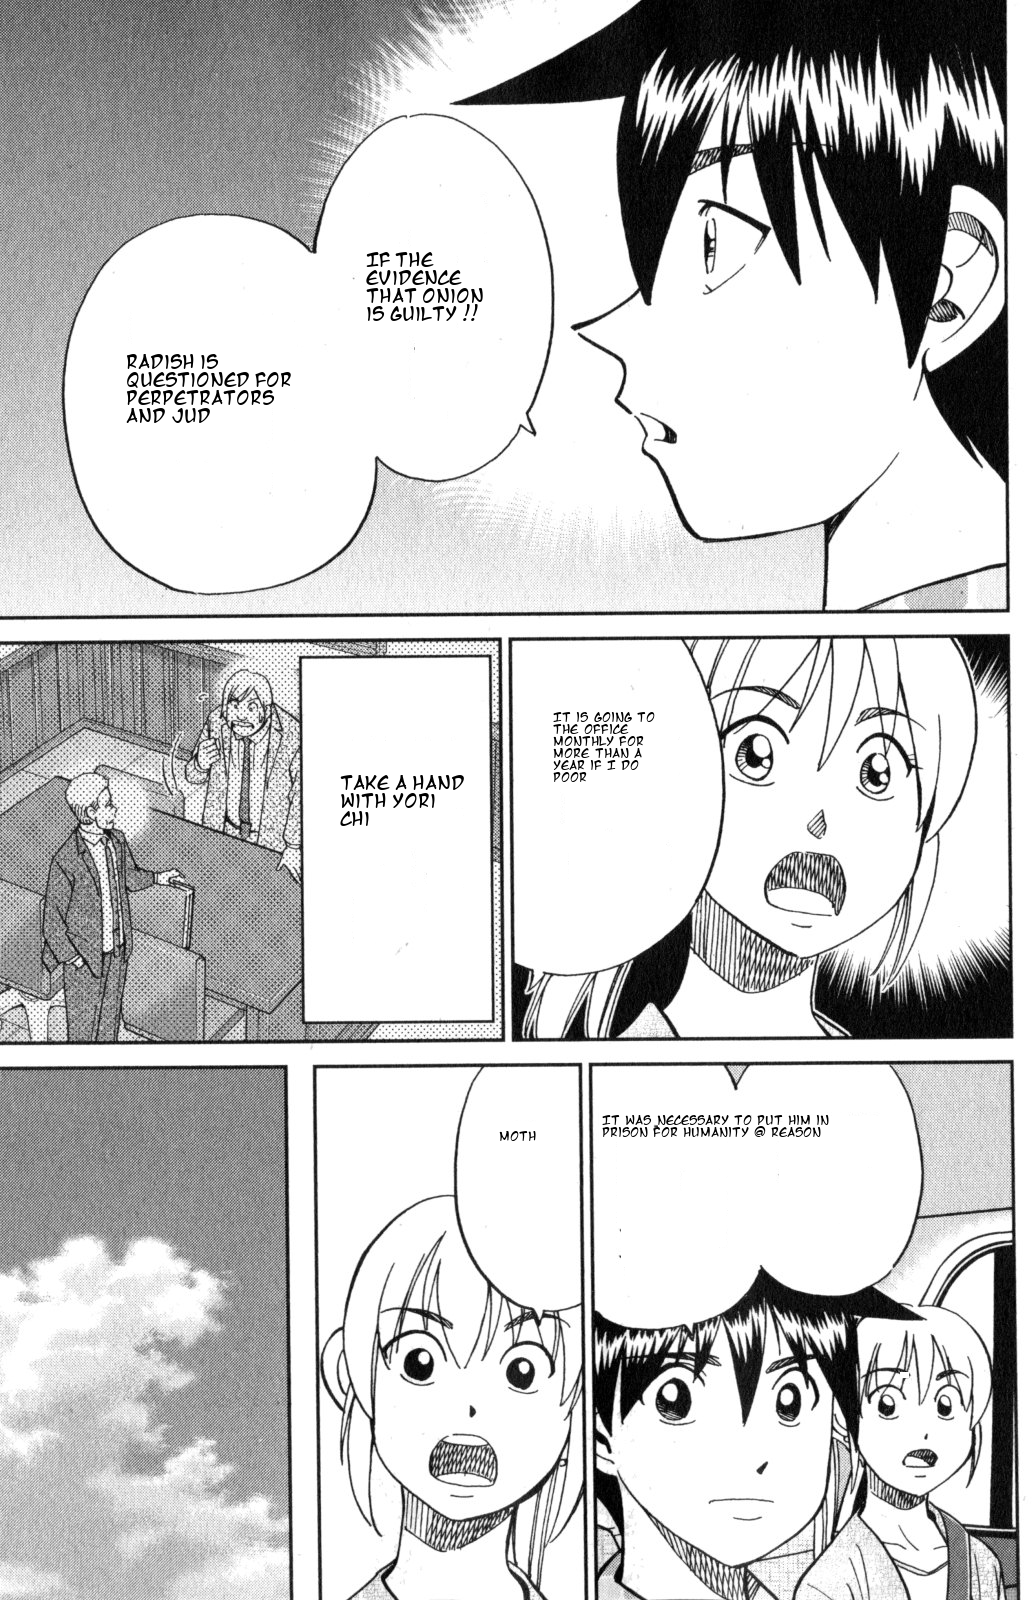

In [20]:
masked_im

In [21]:
masked_im.save(img_path[:-4]+'_tsl.jpg')